<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import time
import warnings #чтоб на ошибки не ругался
warnings.filterwarnings("ignore")

In [2]:
try:
    df= pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])
except:
    df=pd.read_csv('/Users/aleksandrivanov/Downloads/taxi.csv', parse_dates = [0], index_col = [0])
pd.set_option('display.max_columns', None)

In [3]:
df.sort_index(inplace = True)
display(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.isnull().sum()

num_orders    0
dtype: int64

array([[<Axes: title={'center': 'num_orders'}>]], dtype=object)

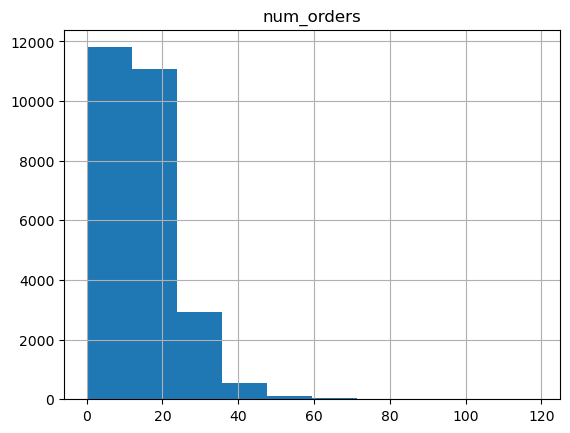

In [7]:
df.hist()

In [8]:
print(df.query('num_orders > 80'))

                     num_orders
datetime                       
2018-08-13 02:20:00         119
2018-08-13 02:30:00          99
2018-08-20 02:00:00          87
2018-08-20 02:10:00          90
2018-08-20 02:20:00          94
2018-08-20 02:30:00          82
2018-08-20 04:00:00          91
2018-08-27 02:00:00          98
2018-08-27 02:10:00         119
2018-08-27 02:20:00          81
2018-08-30 17:50:00          95


In [9]:
df = df.resample('1H').sum()

array([[<Axes: title={'center': 'num_orders'}>]], dtype=object)

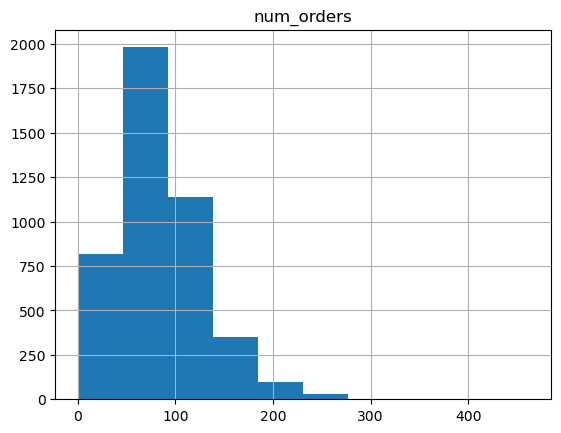

In [10]:
df.hist()

**выводы по разделу:**

Данные довольно-таки чистые, нет пропусков.

Перевели время в индексы, упорядочили, просуммировали в пределах часа. 

Возникают вопросы по выбросам в 119 заказов в один момент, но там и в данных рядом высокие заказы, видимо был какой-то праздник/событие. 

In [11]:
print(df.index.is_monotonic)

True


## Анализ

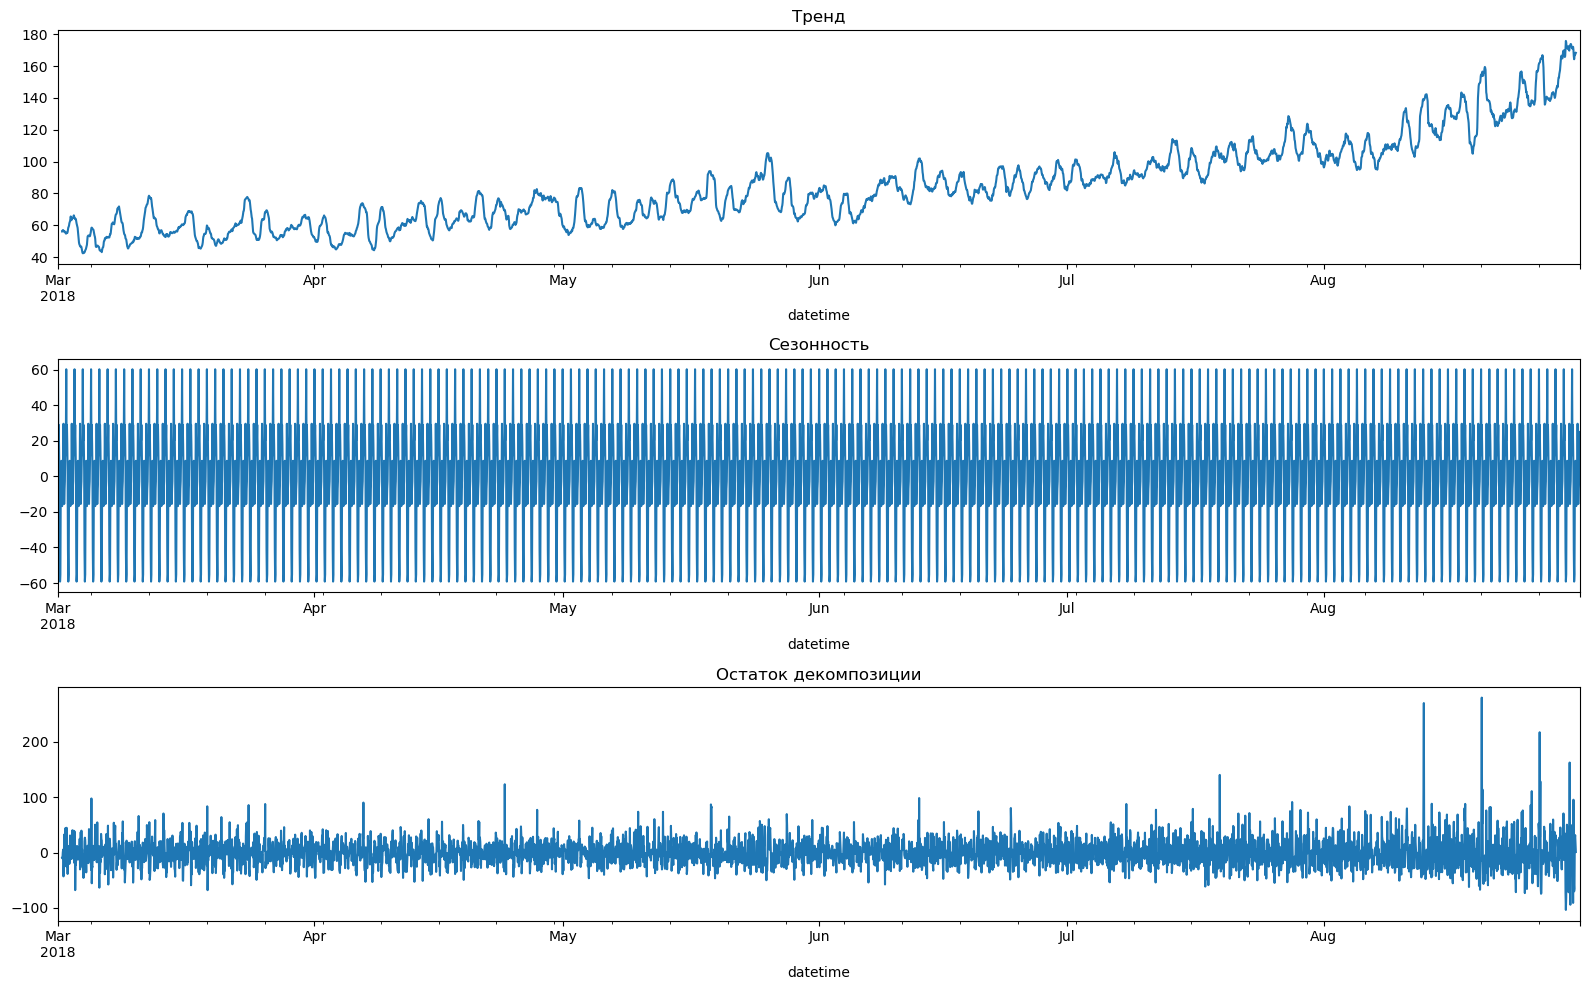

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(16, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.tight_layout()

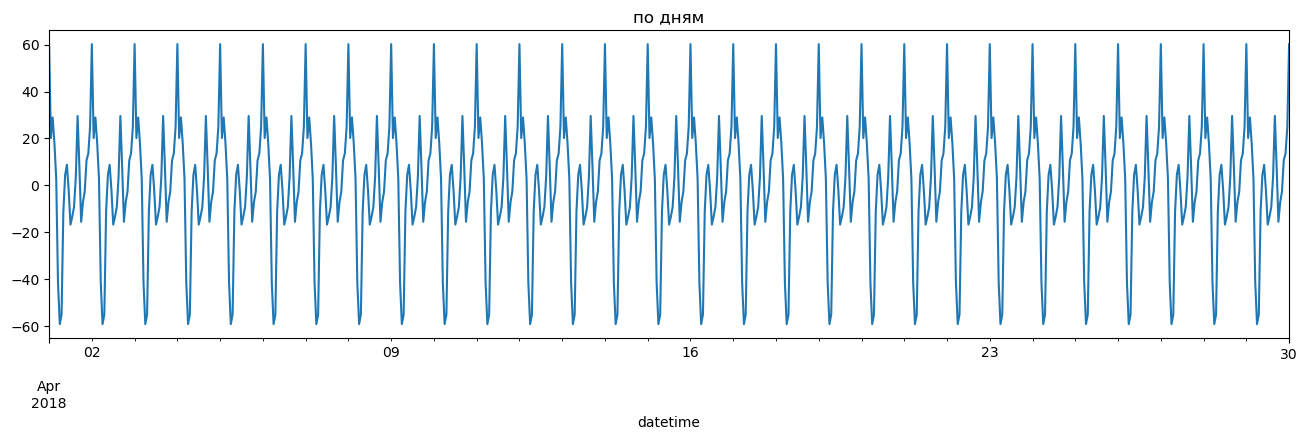

In [13]:
plt.figure(figsize=(16, 4))
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-30 00:00:00'].plot()
plt.title('по дням');

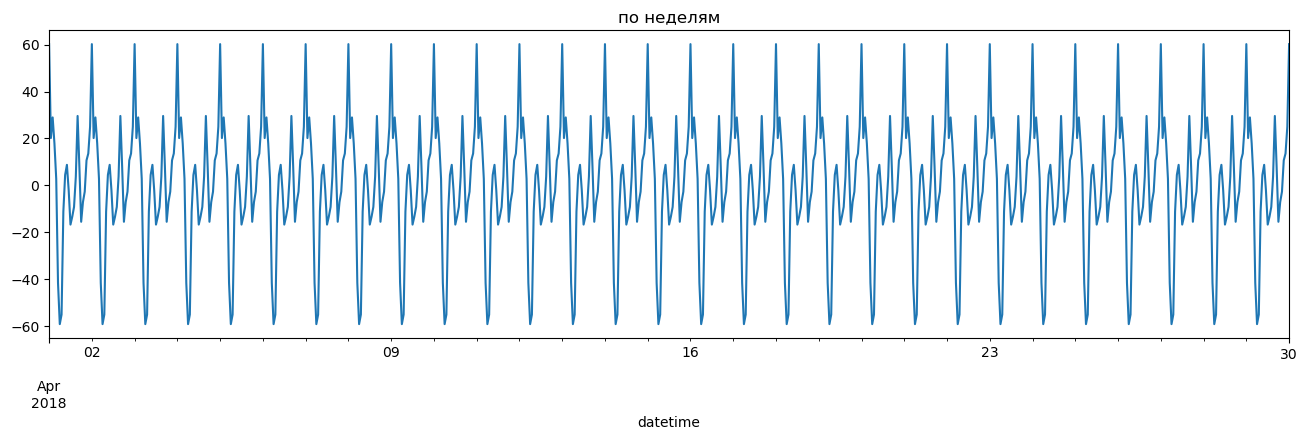

In [14]:
plt.figure(figsize=(16, 4))
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-30 00:00:00'].plot()
plt.title('по неделям');

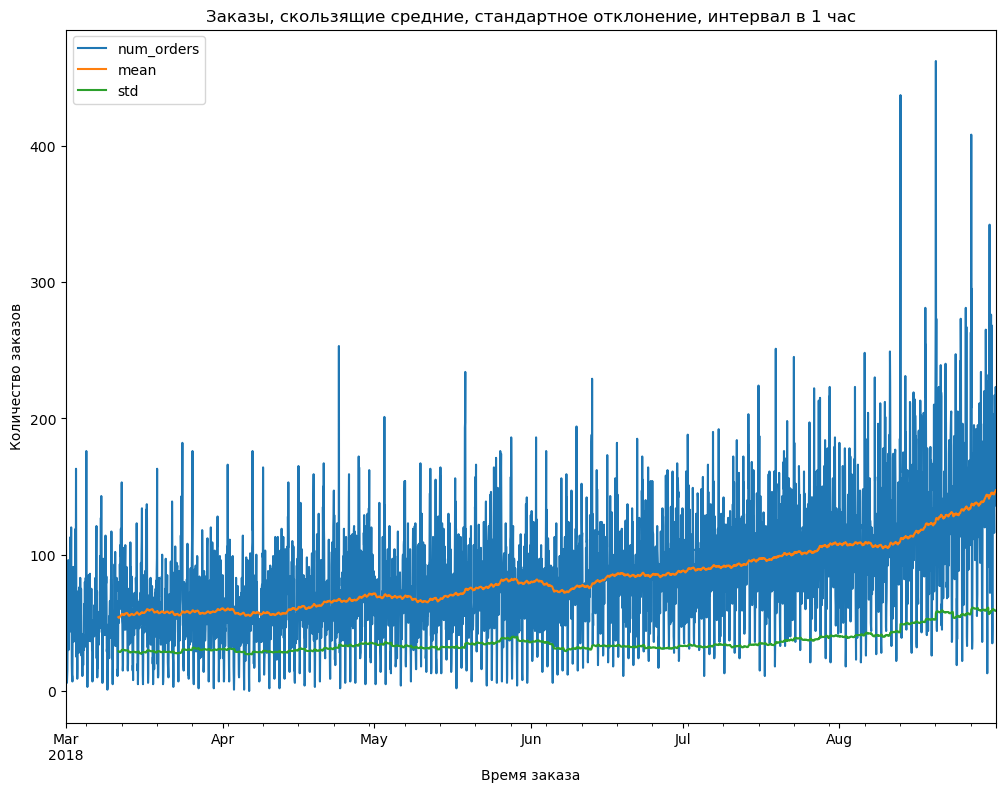

In [15]:
df['mean'] = df['num_orders'].rolling(250).mean()
df['std'] = df['num_orders'].rolling(250).std()
df.plot(figsize=[12,9], title='Заказы, скользящие средние, стандартное отклонение, интервал в 1 час', xlabel='Время заказа', ylabel='Количество заказов')
df = df.drop(['mean', 'std'], axis=1)

## Обучение

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']= data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(df, 1, 24)

In [18]:
df

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print(train.shape)
print(test.shape)
train = train.dropna()
test = test.dropna()

features_train = train.drop(columns='num_orders')
target_train = train['num_orders']

features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

(3974, 5)
(442, 5)


In [20]:
#для работы с временными рядами кросс-валидация требуется специальная, через TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=8)

In [21]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False)

**Линейнай регрессия**

**обучение линейной регрессией**

In [22]:
%%time
start_time = time.time()
model = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model,features_train,
                                                                                              target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()*-1)
line_cv_time = time.time() - start_time

Значение метрики RMSE на обучающей выборке для LinearRegression 31.366763577025026
CPU times: user 38 ms, sys: 71.1 ms, total: 109 ms
Wall time: 1.26 s


**Случайный лес**

In [23]:
%%time
start_time = time.time()
reg_fr = RandomForestRegressor()
parameters_fr = {'max_depth' : range(4,10),
                'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,4),
                'n_estimators': range(20, 50)} 
grid_fr = GridSearchCV(reg_fr, param_grid = parameters_fr, n_jobs = -1, scoring = rmse_scorer, cv = tscv)
model_fr = grid_fr.fit(features_train,target_train) #обучаем
fr_grid_time = time.time() - start_time

CPU times: user 19.7 s, sys: 1.59 s, total: 21.2 s
Wall time: 2min 52s


In [24]:
print(model_fr.best_params_)
print(model_fr.best_score_*-1)#тоже очень даже достойно, причем уверенности в ней больше, чем в ЛР

{'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 42}
24.752964272001755


**А теперь построим подели для сравниня на основе ГБ**

**catboost**

In [25]:
%%time
start_time = time.time()
catboost = CatBoostRegressor(verbose = False) # ВОТ ЗДЕСЬ ВСТАВИЛ verbose = False

params_cat = {'depth':range(1,10), 'learning_rate':np.arange(0.1,0.8)}

catboost_grid = GridSearchCV(catboost, params_cat, cv=tscv, n_jobs = -1, scoring = rmse_scorer)#, verbose = False)
catboost_grid.fit(features_train, target_train)
cat_grid_time = time.time() - start_time

CPU times: user 768 ms, sys: 708 ms, total: 1.48 s
Wall time: 8.77 s


In [26]:
print(catboost_grid.best_params_)
print(catboost_grid.best_score_*-1)

{'depth': 3, 'learning_rate': 0.1}
24.873107900048815


**XGBRegressor**

In [27]:
%%time
start_time = time.time()

params_xgb = {
        'n_estimators': [10,50],
        'max_depth': [3, 8],
        'eta': [0.5, 1]
        }
grid_xgb = GridSearchCV(XGBRegressor(), params_xgb, n_jobs=-1, scoring = rmse_scorer, cv = tscv)

grid_xgb.fit(features_train, target_train)
xgb_grid_time = time.time() - start_time

CPU times: user 146 ms, sys: 45 ms, total: 191 ms
Wall time: 340 ms


In [28]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_*-1)

{'eta': 0.5, 'max_depth': 3, 'n_estimators': 10}
25.60450999694114


**LGBMRegressor**

In [29]:
%%time
start_time = time.time()
param_grid = {
    'num_leaves': [10, 20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10, 20, 50]
}
grid_lgb = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid, cv=tscv, scoring = rmse_scorer)
grid_lgb.fit(features_train, target_train)
lgbm_grid_time = time.time() - start_time

CPU times: user 2min 8s, sys: 1min 20s, total: 3min 28s
Wall time: 58.1 s


In [30]:
print(grid_lgb.best_params_)
print(grid_lgb.best_score_*-1)

{'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}
24.56336611723505


Все модели по значениям прям рядом друг с другом, немного вперед вырвался кот под гридом =) 

In [31]:
print('линейна регресси', line_cv_time)
print ('Лес', fr_grid_time)
print ('Catboost с гридом', cat_grid_time )
print ('XBB c гридом', xgb_grid_time )
print ('LGBM с гридом', lgbm_grid_time)

линейна регресси 1.261749029159546
Лес 172.45111393928528
Catboost с гридом 8.768630027770996
XBB c гридом 0.34006500244140625
LGBM с гридом 58.05159902572632


## Тестирование

In [32]:
final_test = catboost_grid.predict(features_test)
print(rmse(target_test, final_test))

47.25551999128378


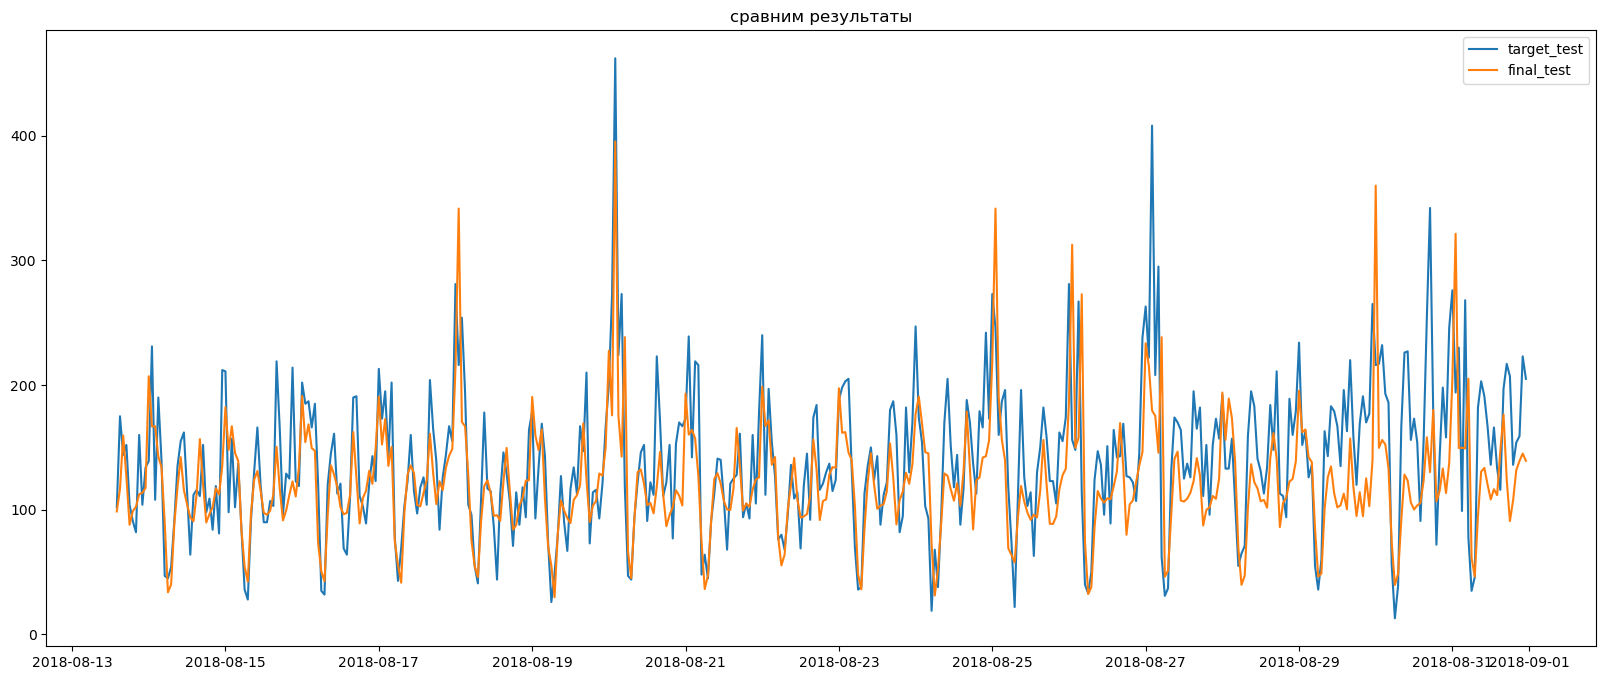

In [33]:
plt.figure(figsize=(20, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, final_test, label='final_test')

plt.title('сравним результаты')
plt.legend()
plt.show()

**Вывод**

Модель catboost достигла требуемого результата на тестовой выборке